In [2]:
import torch
from torch import nn

class Upsample(nn.Module):
    def __init__(self, in_c, scale_factor = 2, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_channels=in_c, out_channels=in_c, kernel_size=3, stride=1, padding=1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

torch.Size([1, 3, 853, 640])


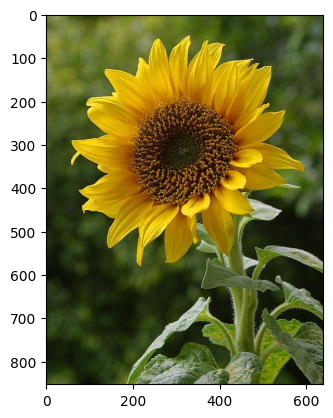

In [33]:
import matplotlib.pyplot as plt
test_input = torch.tensor(plt.imread("tset.jpg"))
if test_input.max() > 1.0:
    test_input = test_input / 255.0

plt.imshow(test_input)


test_input = test_input.unsqueeze(0).permute(0, 3, 1, 2)
print(test_input.shape)


plt.show()

In [52]:
output = Upsample(3, scale_factor=2)(test_input)
output.shape

torch.Size([1, 3, 1706, 1280])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


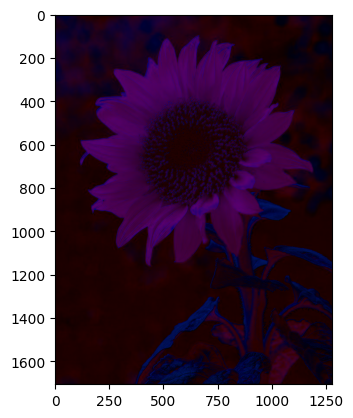

In [53]:
plt.imshow(output.permute(2,3,1,0).squeeze(-1).detach().numpy())

In [ ]:
nn.Conv2d(kernel_size=)

In [59]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, *args, **kwargs):
        super().__init__()

        self.cnn = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            **kwargs
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()
    def forward(self, x):
        return self.act(self.cnn(x))
    

class DenseBlock(nn.Module):
    def __init__(self, in_channels, channels=32, resudual_beta = 0.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.resudual_beta = resudual_beta
        self.block = nn.ModuleList()

        for i in range(5):
            self.block.append(
                ConvBlock(
                    in_channels = in_channels+channels * i,
                    out_channels = channels if i <= 3 else in_channels,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1,
                    use_act = True if i <= 3 else False,
                )
            )
    def forward(self, x):
        new_inputs = x
        for block in self.block:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.resudual_beta * out + x
    
DenseBlock(3)

DenseBlock(
  (block): ModuleList(
    (0): ConvBlock(
      (cnn): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): ConvBlock(
      (cnn): Conv2d(35, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): ConvBlock(
      (cnn): Conv2d(67, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): ConvBlock(
      (cnn): Conv2d(99, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): ConvBlock(
      (cnn): Conv2d(131, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): Identity()
    )
  )
)

In [10]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
from torchvision.models import vgg19
from torch import nn
import config

class VGGloss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:35].eval().to(config.DEVICE)

        for param in self.vgg.parameters():
            param.requires_grad = False
            
        self.loss = nn.MSELoss()

    def forward(self, input, target):
        input_features = self.vgg(input)
        target_features = self.vgg(target)
        return self.loss(input_features, target_features)

In [16]:
import torch
a = torch.rand([10,3,500,500])
b = torch.rand([10,3,500,500])

l = VGGloss()

l(a,b)

tensor(0.0483)

In [26]:
BATCH_SIZE, C, H, W = [10, 3, 100, 100]
torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W)

tensor([[[[0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          ...,
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281]],

         [[0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          ...,
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281]],

         [[0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0.1281, 0.1281, 0.1281],
          [0.1281, 0.1281, 0.1281,  ..., 0

In [25]:
torch.rand((1, 1, 1)).repeat(1, C, H, W)

tensor([[[[0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          ...,
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987]],

         [[0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          ...,
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987]],

         [[0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0.9987, 0.9987, 0.9987],
          [0.9987, 0.9987, 0.9987,  ..., 0

In [47]:
BATCH_SIZE, C, H, W = [10, 3, 100, 100]
real = torch.rand([10, 3, 100, 100])
fake = torch.rand([10, 3, 100, 100])

alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W)

interpolated_images = real * alpha + fake.detach() * (1 - alpha)
interpolated_images.requires_grad_(True)

critic = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(C * H * W, 1)  # A simple critic for demonstration
)

mixed_scores = critic(interpolated_images)

gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

gradient = gradient.view(gradient.shape[0], -1)
gradient_norm = gradient.norm(2, dim=1)
gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
return gradient_penalty

In [49]:
checkpoint = torch.load('gen.pth', map_location=config.DEVICE)
print(checkpoint.keys())  # Check the available keys in the checkpoint

dict_keys(['state_dict', 'optimizer'])


/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_41499/2693928961.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('gen.pth', map_locati

In [10]:
import numpy as np
from PIL import Image


image_path = 'test_images/baboon_LR.png'
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)
transformed = config.test_transform(image=image_np)
image_tensor = transformed['image'].permute(1,2,0)
print(image_tensor.shape)  # Should be in the form [C, H, W]

torch.Size([120, 125, 3])


In [2]:
import numpy as np
from model import Generator, Discriminator, initialize_weights
import config
import torch
from torchvision.utils import save_image
from torch import optim

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using im

In [3]:
gen = Generator(in_channels=3).to(config.DEVICE)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.9))


checkpoint = torch.load('gen.pth', map_location=config.DEVICE)
# model.load_state_dict(checkpoint)
gen.load_state_dict(checkpoint["state_dict"])
opt_gen.load_state_dict(checkpoint["optimizer"])

# If we don't do this then it will just have learning rate of old checkpoint
# and it will lead to many hours of debugging \:
for param_group in opt_gen.param_groups:
    param_group["lr"] = config.LEARNING_RATE

/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_44512/2690894598.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('gen.pth', map_locati

In [6]:
from PIL import Image

image_path = 'test_images/baboon_LR.png'
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)
transformed = config.test_transform(image=image_np)
image_tensor = transformed['image'].permute(1,2,0)
print(image_tensor.shape)  # Should be in the form [C, H, W]

gen = Generator(in_channels=3).to(config.DEVICE)

gen.eval()

upscaled = gen(
            config.test_transform(image=np.asarray(image_tensor))["image"]
            .unsqueeze(0)
            .to(config.DEVICE)
            )
save_image(upscaled, f"saved/{'try.jpg'}")

torch.Size([120, 125, 3])
